In [1]:
import numpy as np 
import time
import os 
import matplotlib.pyplot as plt
from HPO.utils.model import NetworkMain
from HPO.utils.DARTS_utils import config_space_2_DARTS
from HPO.utils.FCN import FCN 
import pandas as pd
import torch
from HPO.data.teps_datasets import Train_TEPS , Test_TEPS
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler
import random
import HPO.utils.augmentation as aug
from HPO.utils.train_utils import collate_fn_padd
from HPO.utils.train import train_model, auto_train_model
from HPO.utils.weight_freezing import freeze_FCN, freeze_resnet
from HPO.utils.ResNet1d import resnet18
from HPO.utils.files import save_obj
from queue import Empty
from sklearn.model_selection import StratifiedKFold as KFold
from collections import namedtuple
from HPO.utils.worker_score import Evaluator 
from HPO.utils.worker_utils import LivePlot
import seaborn as sns

In [29]:
hpo = {'channels': 64, 'lr': 0.0250170869707739693, 'p': 0.0, 'epochs': 30, 'layers': 3}
hyperparameter = {'normal_index_0_0': 0, 'normal_index_0_1': 1, 'normal_index_1_0': 2, 'normal_index_1_1': 1, 'normal_index_2_0': 3, 'normal_index_2_1': 2, 
                  'normal_index_3_0': 2, 'normal_index_3_1': 4, 'normal_node_0_0': 'dil_conv_3x3', 'normal_node_0_1': 'none', 'normal_node_1_0': 'sep_conv_5x5', 
                  'normal_node_1_1': 'max_pool_3x3', 'normal_node_2_0': 'avg_pool_3x3', 'normal_node_2_1': 'sep_conv_7x7', 'normal_node_3_0': 'skip_connect', 
                  'normal_node_3_1': 'sep_conv_7x7', 'reduction_index_0_0': 0, 'reduction_index_0_1': 0, 'reduction_index_1_0': 1, 'reduction_index_1_1': 1, 
                  'reduction_index_2_0': 1, 'reduction_index_2_1': 3, 'reduction_index_3_0': 2, 'reduction_index_3_1': 2, 'reduction_node_0_0': 'none', 
                  'reduction_node_0_1': 'skip_connect', 'reduction_node_1_0': 'sep_conv_7x7', 'reduction_node_1_1': 'sep_conv_5x5', 'reduction_node_2_0': 'dil_conv_5x5', 
                  'reduction_node_2_1': 'skip_connect', 'reduction_node_3_0': 'skip_connect', 'reduction_node_3_1': 'sep_conv_5x5'    }

hyperparameter.update(hpo)
gen = config_space_2_DARTS(hyperparameter,reduction = True)
model = NetworkMain(52,hyperparameter["channels"],num_classes= 3 , 
                  layers = hyperparameter["layers"], auxiliary = False,drop_prob = hyperparameter["p"], genotype = gen, binary = False)

model = model.cpu()

In [30]:
weights = torch.load("/home/cmackinnon/scripts/HPO/triplet-{}".format(45),map_location = torch.device('cpu'))

In [31]:
model.load_state_dict(weights)

<All keys matched successfully>

In [32]:
model = model.cuda(0)

In [84]:
binary = False
THRESHOLD = 0.4
batch_size = 64
model.eval()
dataset_train = Train_TEPS(binary = False,samples_per_class = 500, one_hot = False, window_size = 50)
trainloader = torch.utils.data.DataLoader(
                  dataset_train,collate_fn = collate_fn_padd,shuffle = True,
                  batch_size=batch_size,drop_last = True)

In [56]:
dataset_test = Test_TEPS(binary = False,samples_per_class = 500, one_hot = False)
testloader = torch.utils.data.DataLoader(
                  dataset_test,collate_fn = collate_fn_padd,shuffle = True,
                  batch_size=batch_size,drop_last = True)

In [37]:
model = model.eval()

In [38]:
test_embedded = np.zeros((128,100))

In [39]:
test_labels = []
for i, (sample, label) in enumerate(testloader):

    embedded = model(sample).cpu().detach().numpy()

    if i == 0:
        test_embedded = embedded
    else:
        test_embedded = np.concatenate((test_embedded,embedded),axis = 0)
    if i == 0:
        test_labels = label.cpu().detach().numpy()
    else:
        test_labels = np.concatenate((test_labels,label.cpu().detach().numpy()),axis = 0)  


In [40]:
train_embedded = []
train_labels = []
for i, (sample, label) in enumerate( trainloader):
    embedded = model(sample).cpu().detach().numpy()
    if i == 0:
        train_embedded = embedded
    else:
        train_embedded = np.concatenate((train_embedded,embedded),axis = 0)
    if i == 0:
        train_labels = label.cpu().detach().numpy()
    else:
        train_labels = np.concatenate((train_labels,label.cpu().detach().numpy()),axis = 0)  
        

In [86]:
s,l = next(iter(trainloader))
s.shape

torch.Size([64, 52, 480])

In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
knn = KNeighborsClassifier(5)

In [43]:
train_embedded.shape

(960, 3)

In [58]:
for i, (sample, label) in enumerate( trainloader):
    if i == 0:
        samples = sample.cpu().numpy()
    else:
        samples = np.concatenate((samples,sample.cpu().numpy()),axis = 0)
    if i == 0:
        labels = label.cpu().numpy()
    else:
        labels = np.concatenate((labels ,label.cpu().numpy()),axis = 0)

In [45]:
knn = knn.fit(train_embedded, train_labels)

In [46]:
knn.score(train_embedded, train_labels)

0.5229166666666667

In [47]:
knn.score(test_embedded, test_labels) 

0.4979166666666667

In [48]:
pred = knn.predict(test_embedded)

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
with np.printoptions(linewidth = (10*21),precision=4, suppress=True):
    print(confusion_matrix(pred,test_labels))

[[234 231]
 [251 244]]


In [51]:
train_embedded.shape

(960, 3)

In [52]:
np.save("embedding",train_embedded)
np.save("embedding_labels",train_labels)

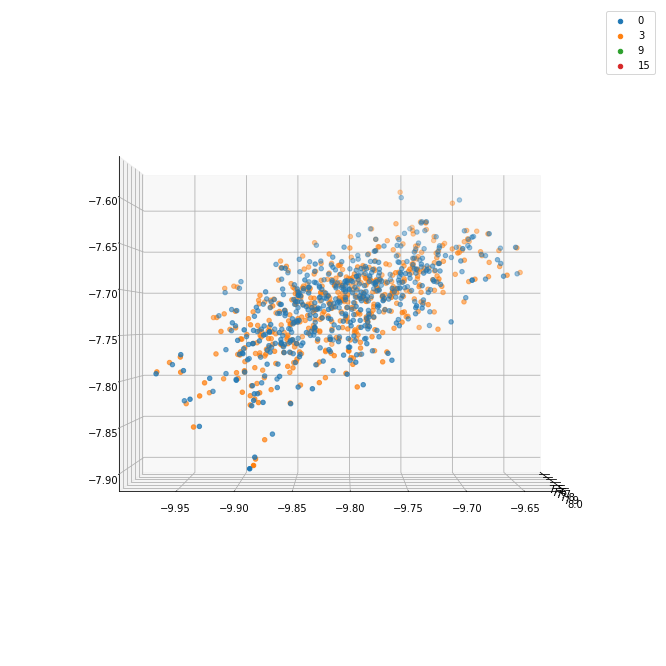

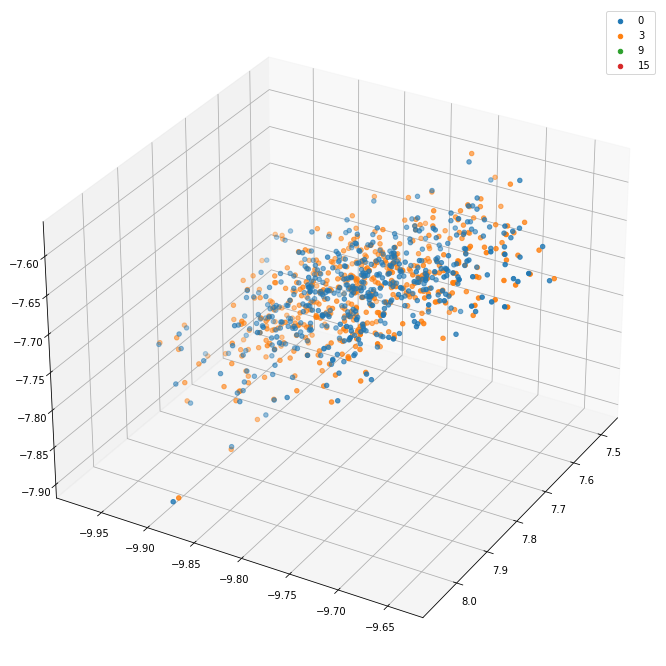

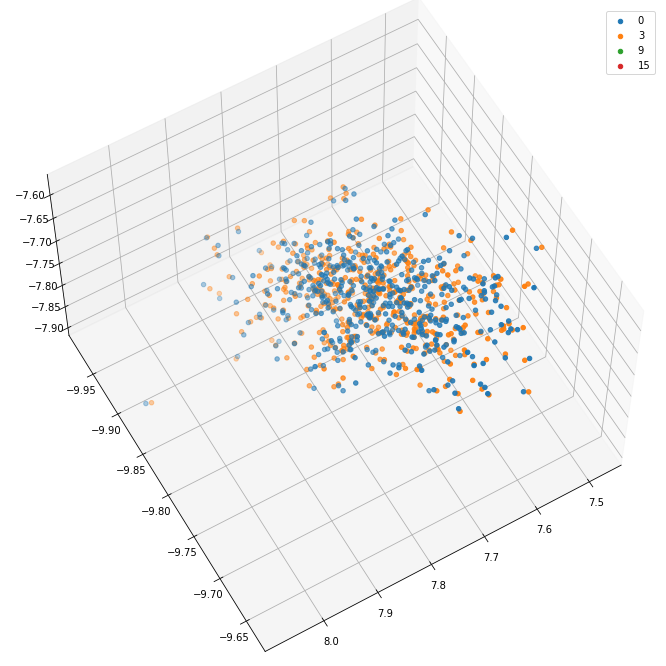

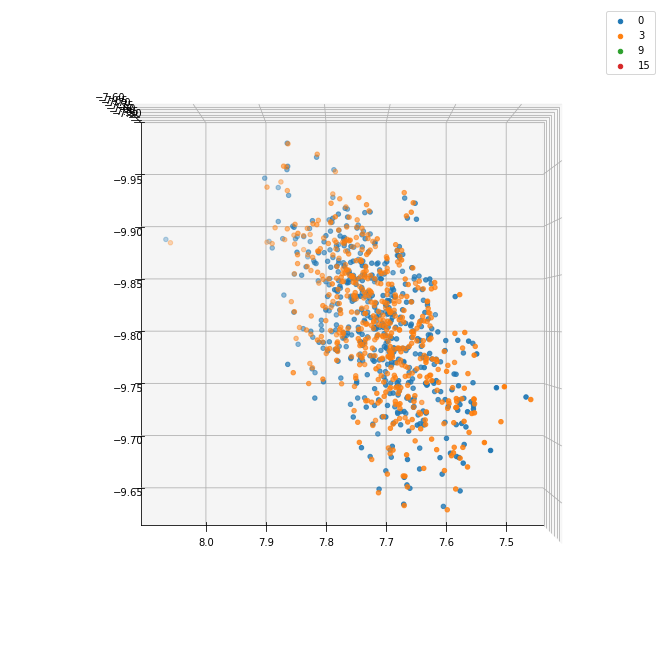

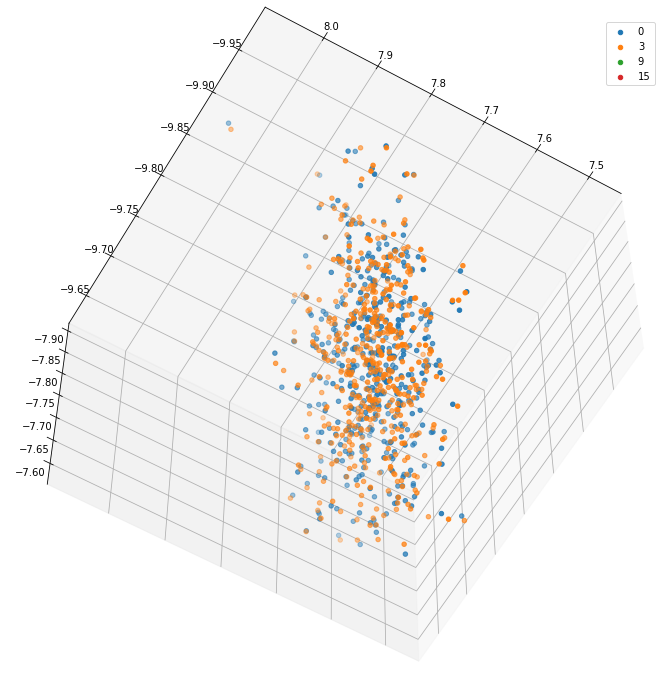

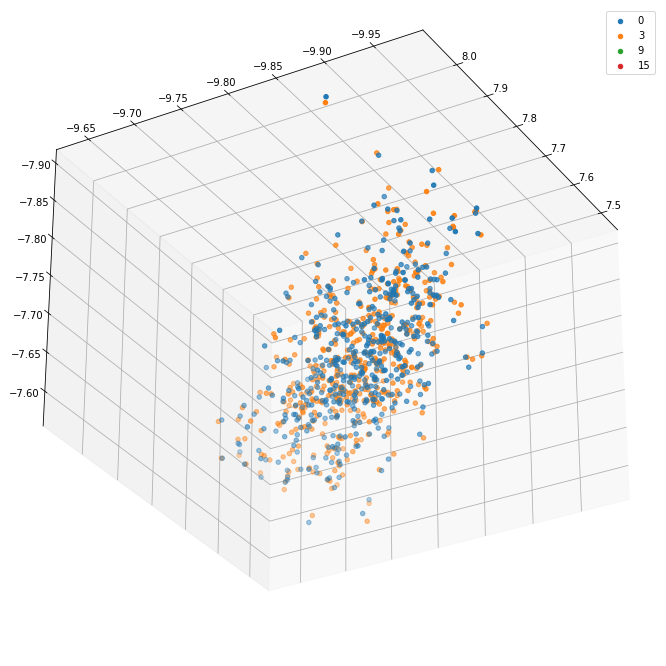

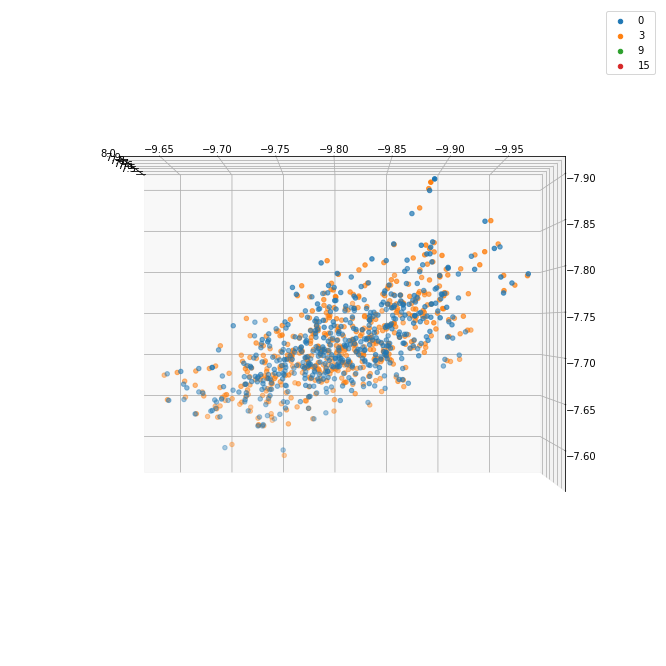

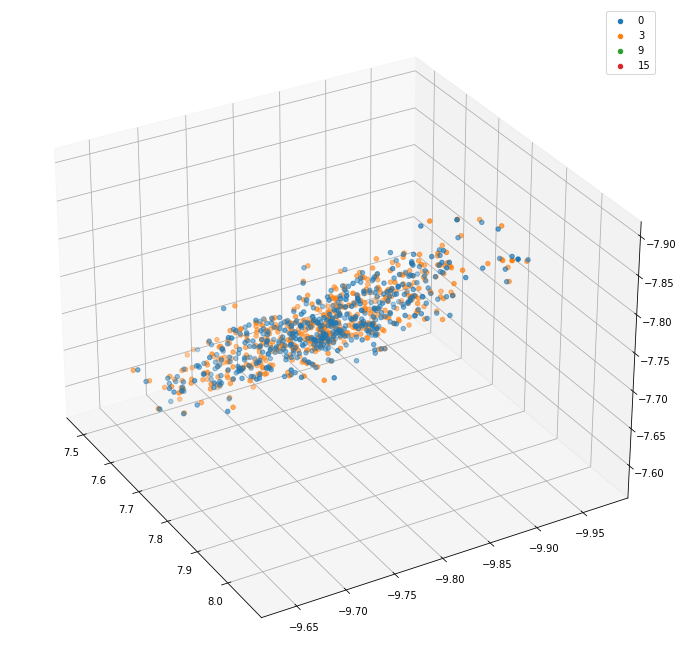

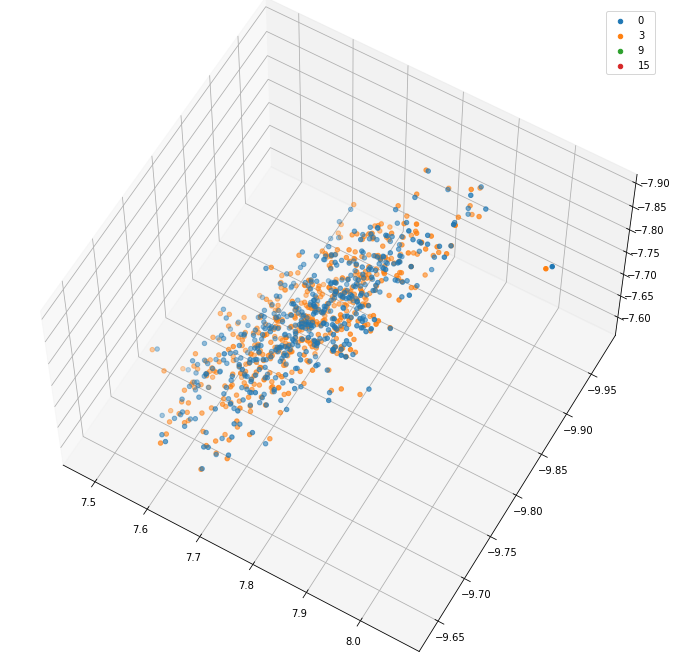

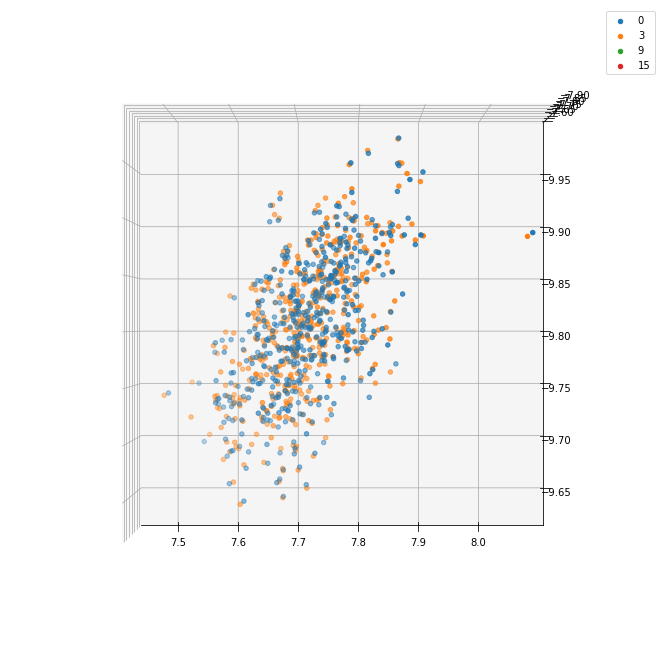

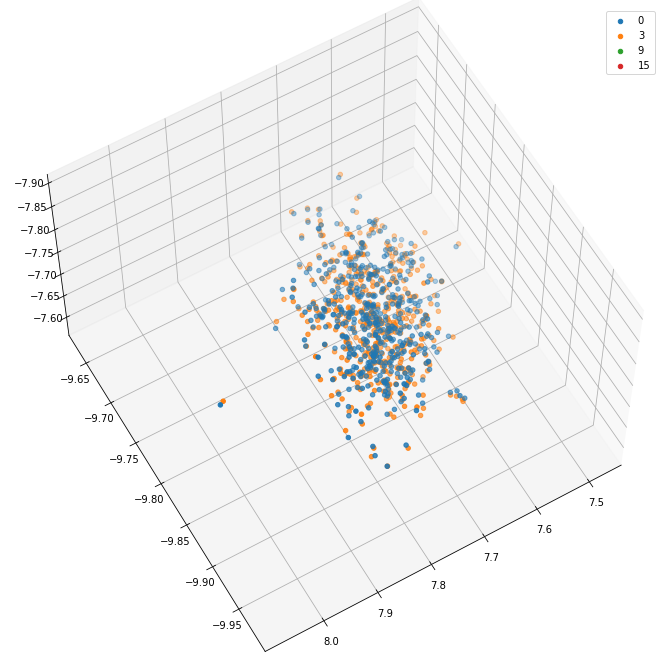

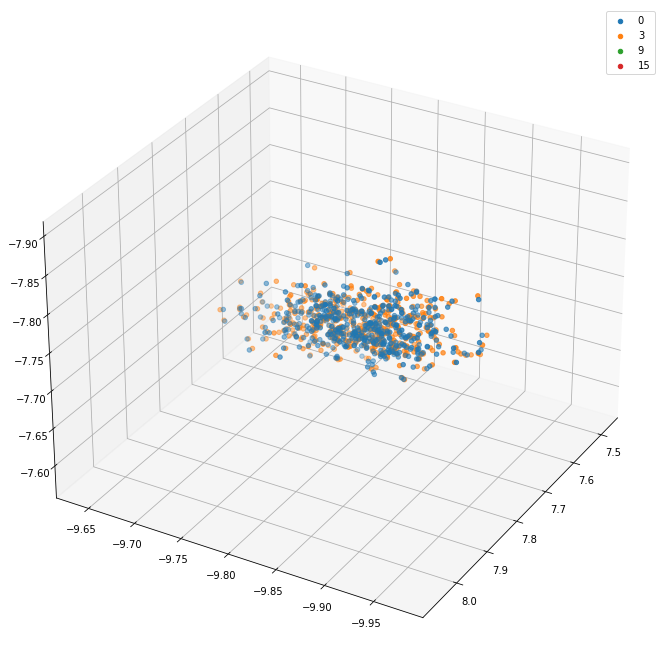

In [53]:
%matplotlib inline

for angle in range(0, 360,30):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    for i in [0,3,9,15]:
        idx = np.where(train_labels ==i)
        ax.scatter(train_embedded[idx,0],train_embedded[idx,1],train_embedded[idx,2],label = i)
    plt.legend()
    ax.view_init(angle, angle)
    plt.draw()
    plt.pause(.001)



In [59]:
samples.shape

(10496, 52, 480)

In [62]:
class_3 = np.where(labels ==3 )

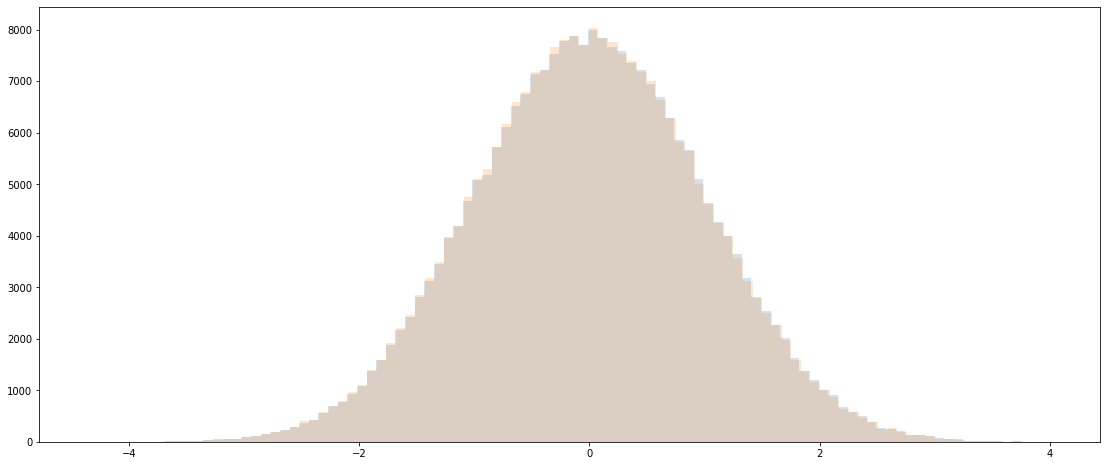

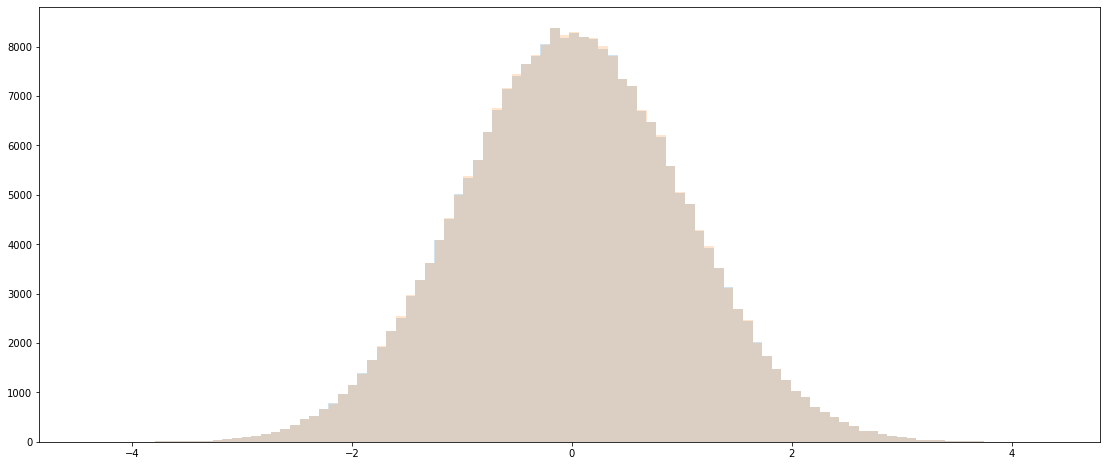

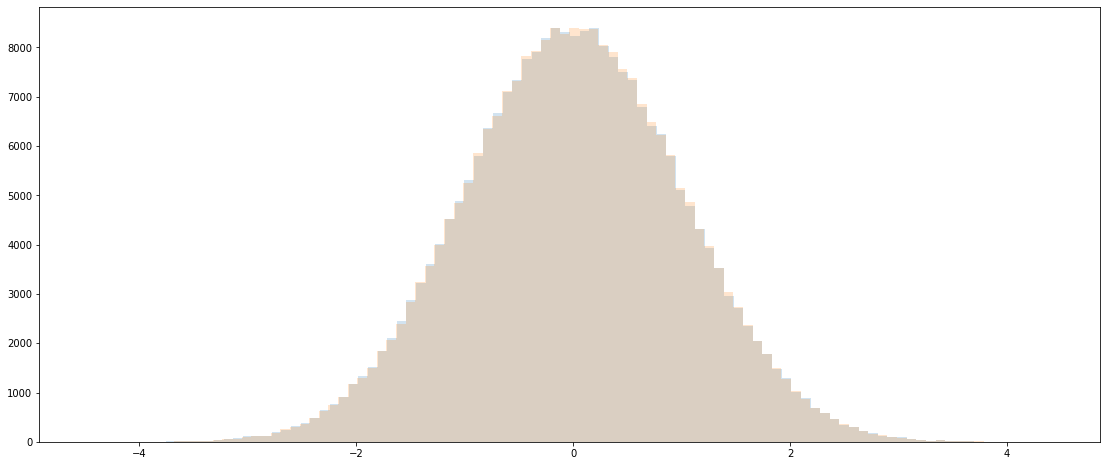

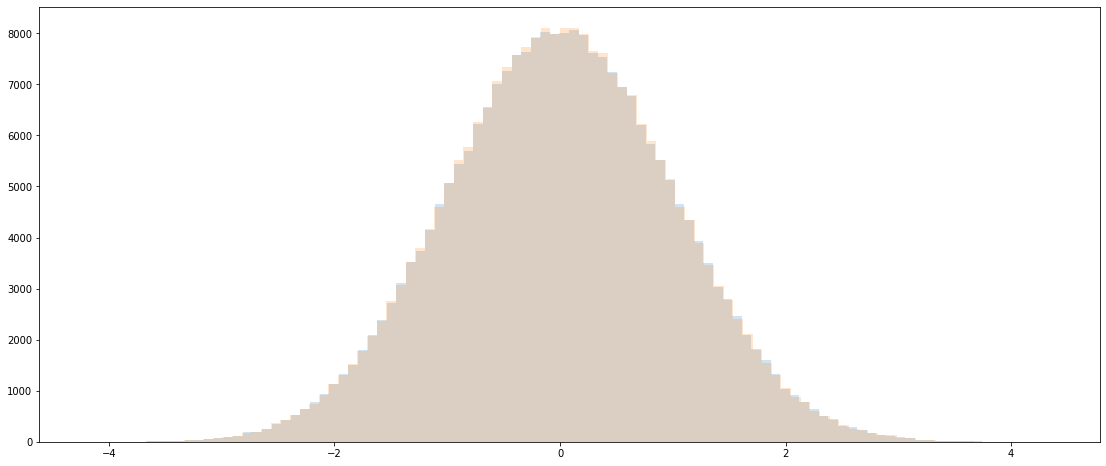

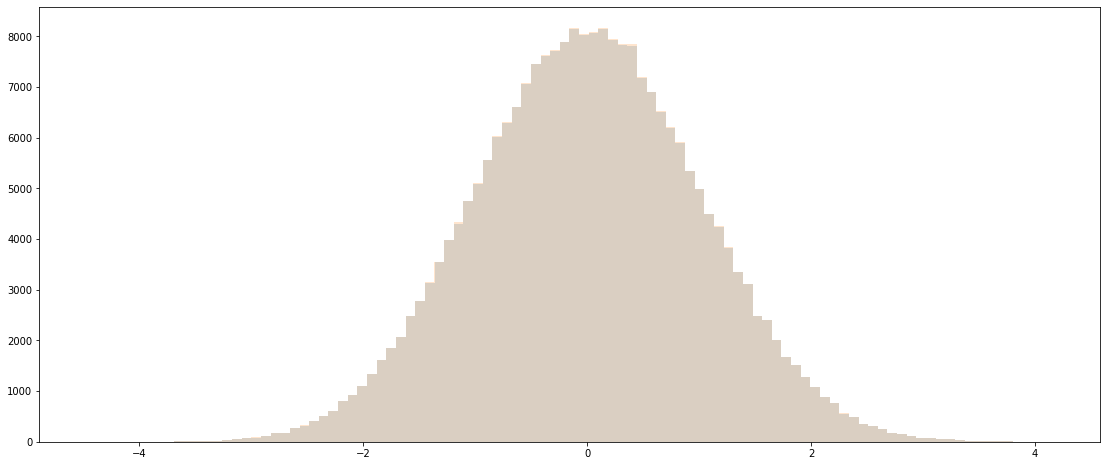

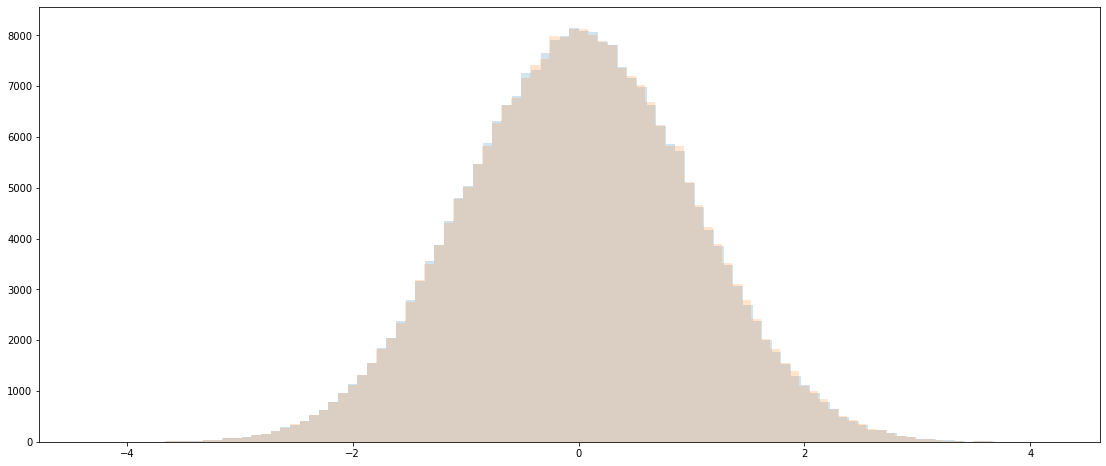

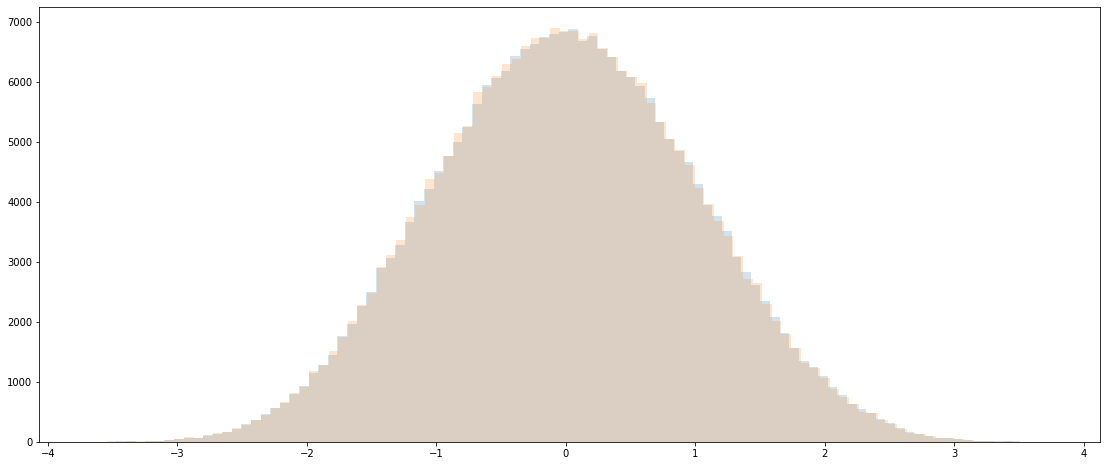

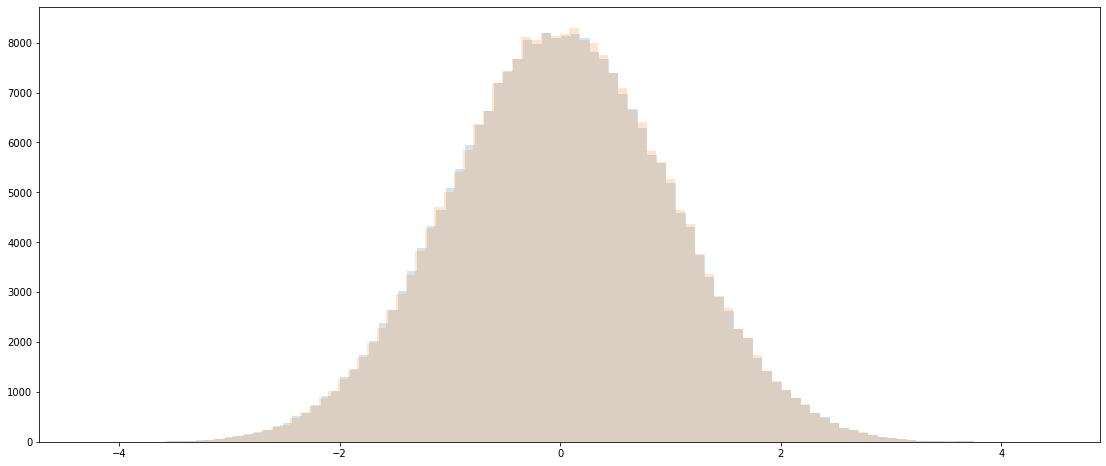

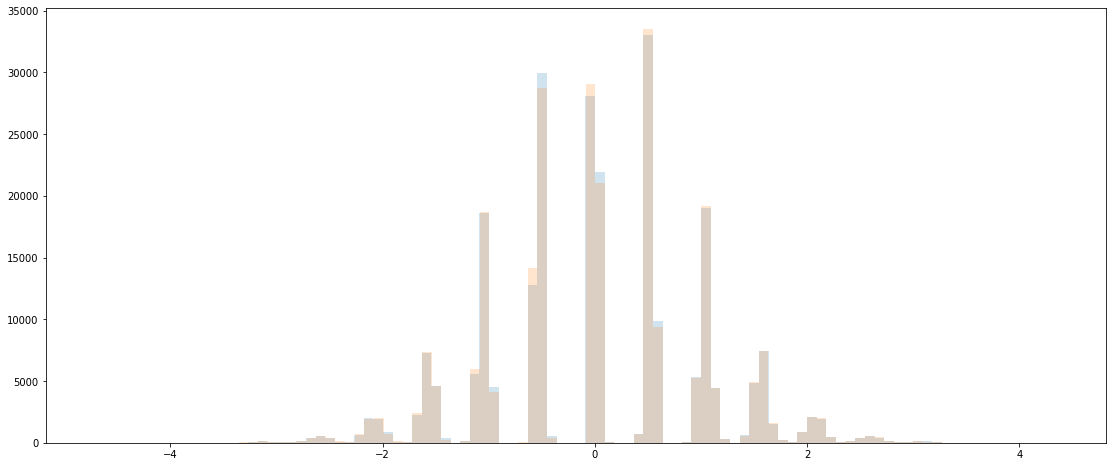

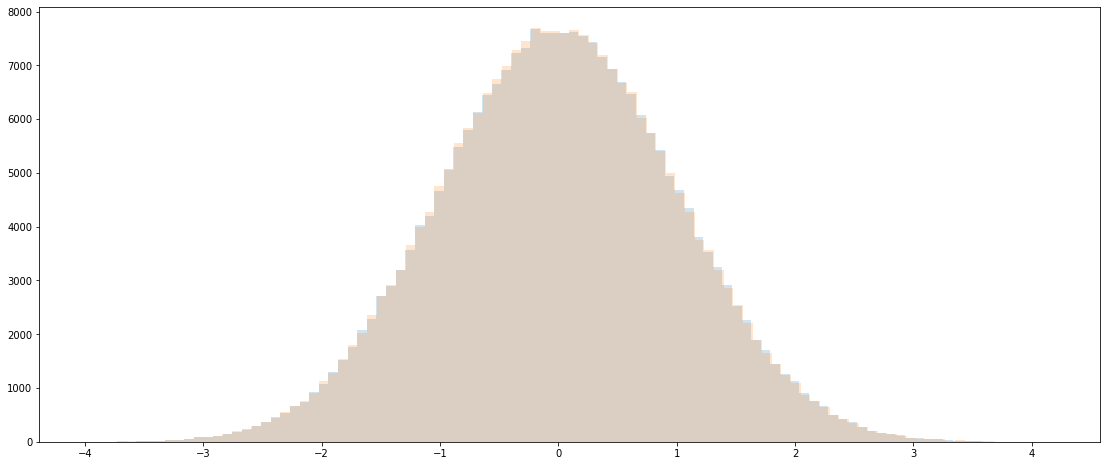

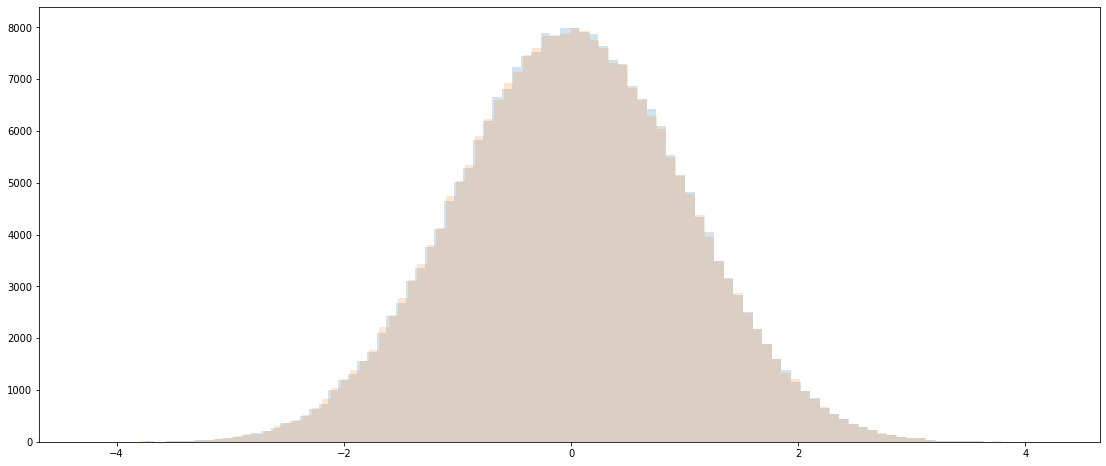

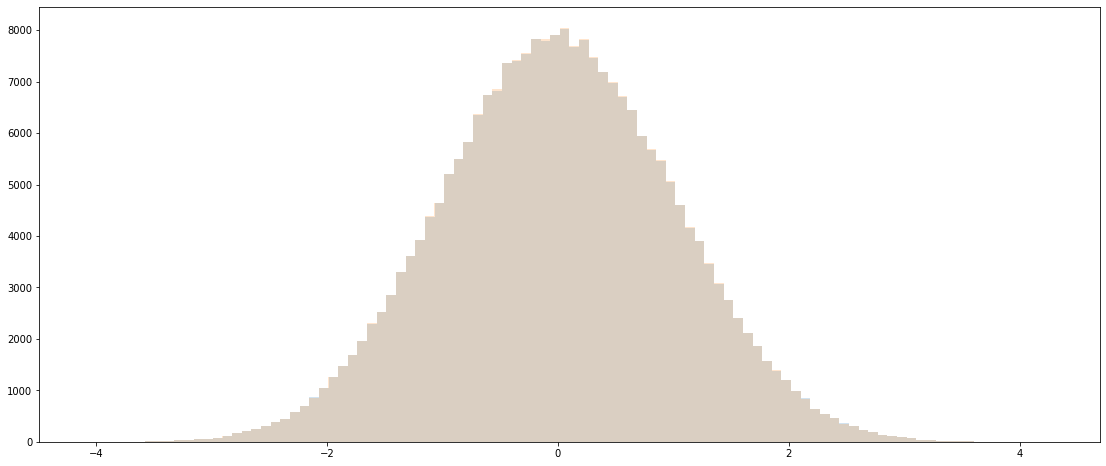

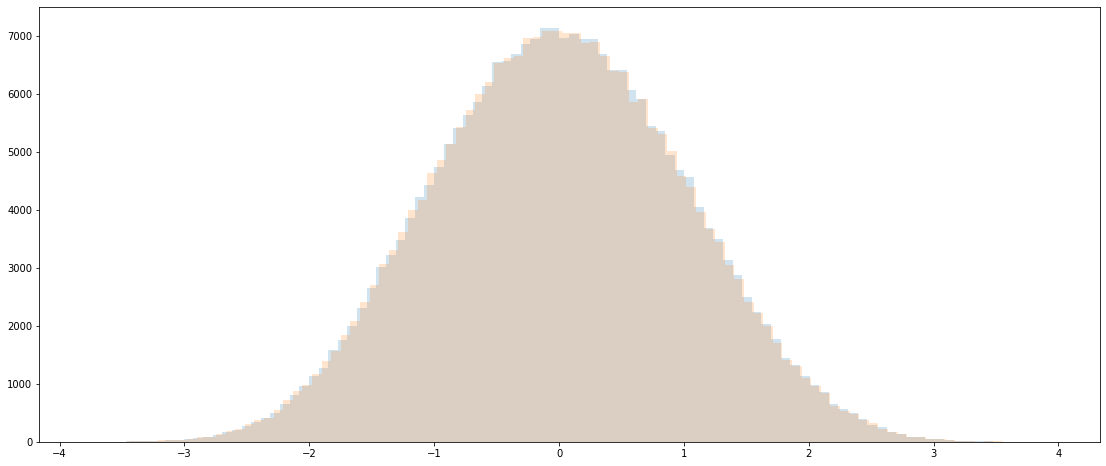

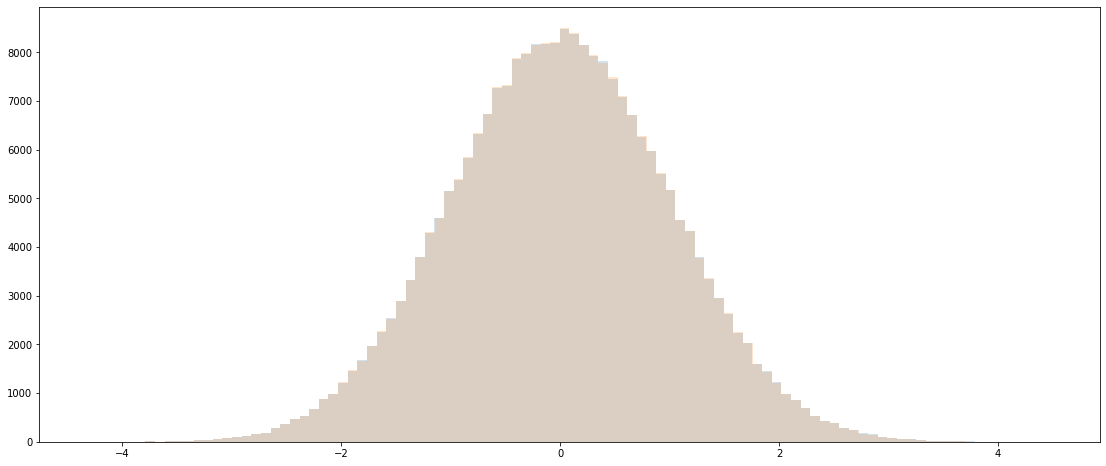

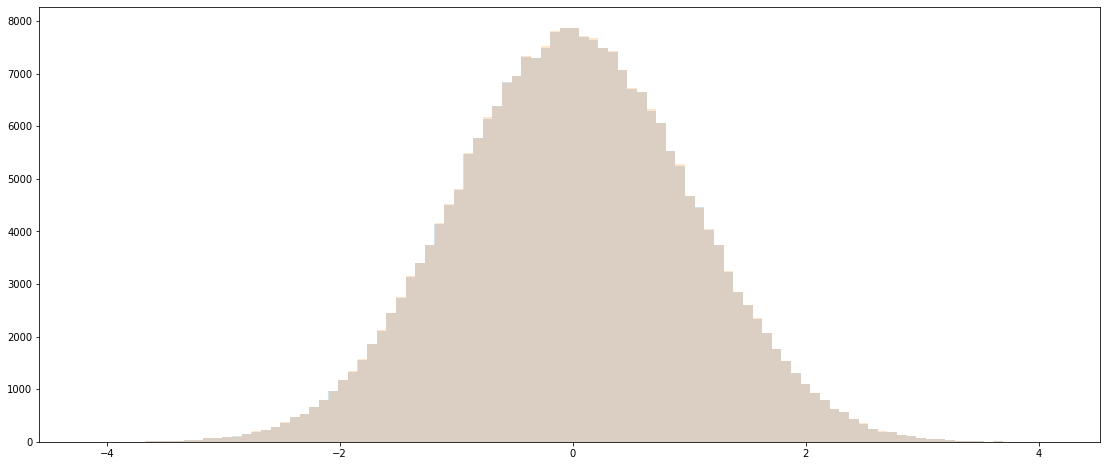

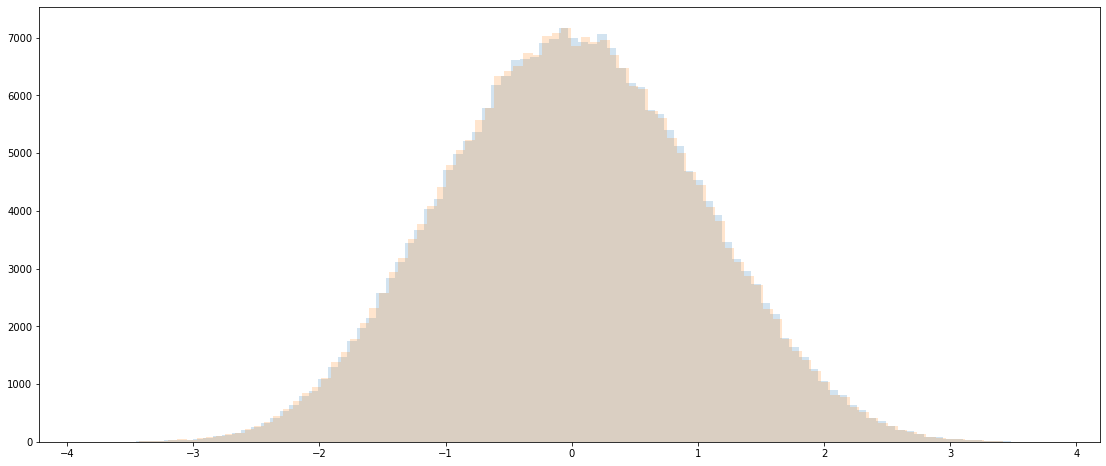

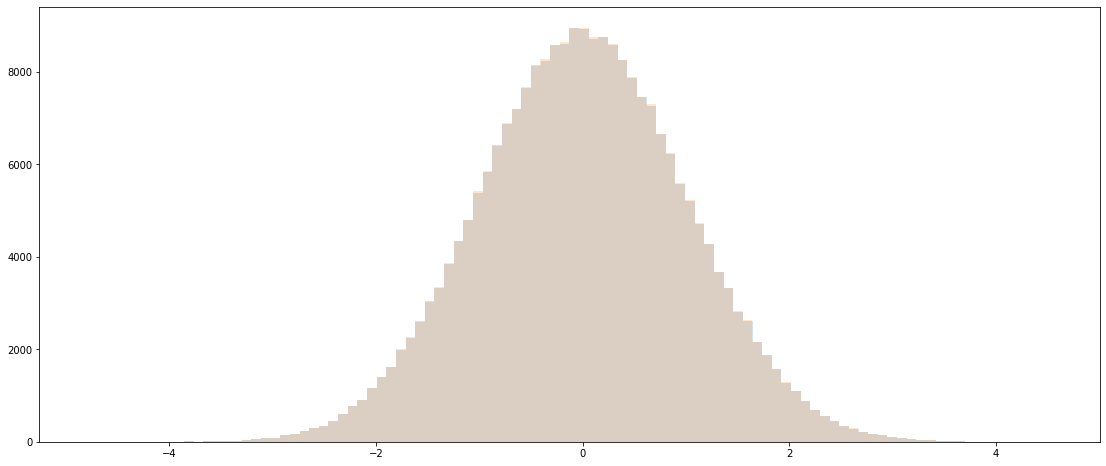

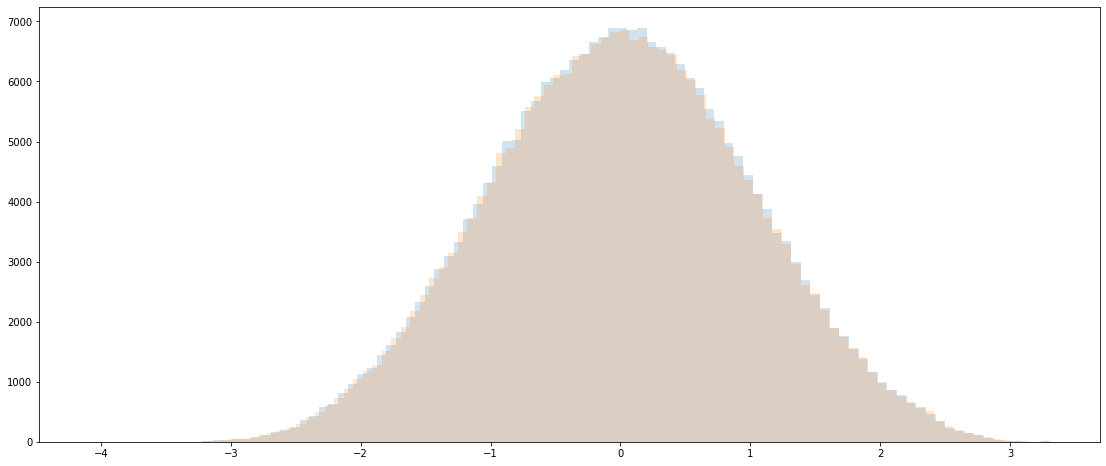

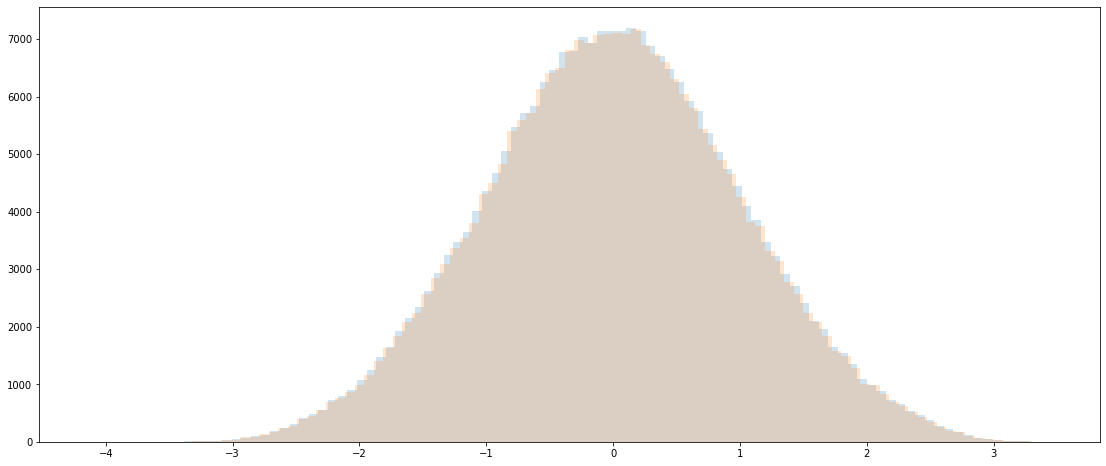

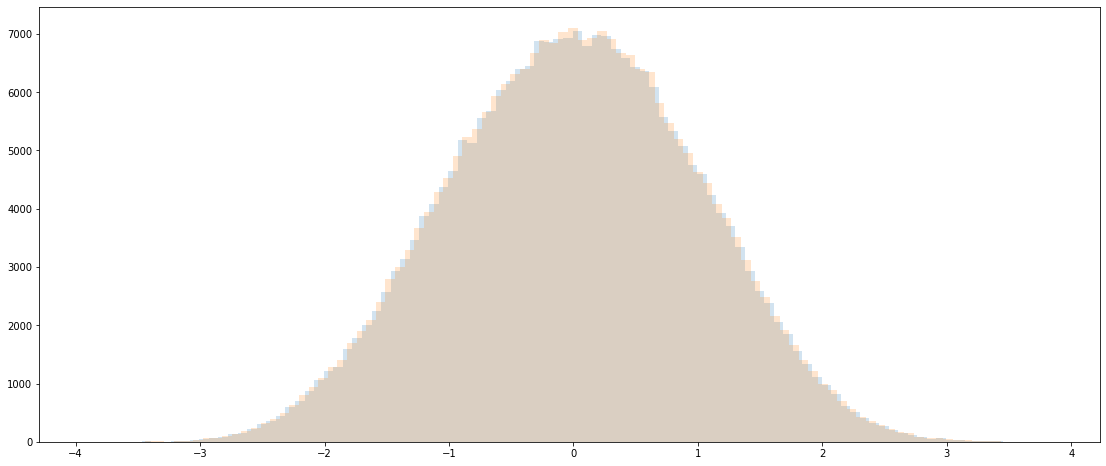

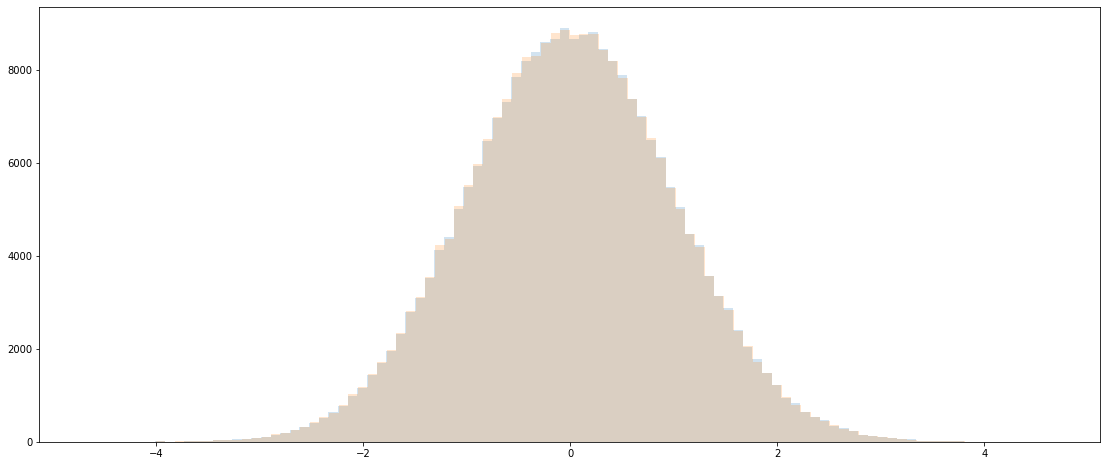

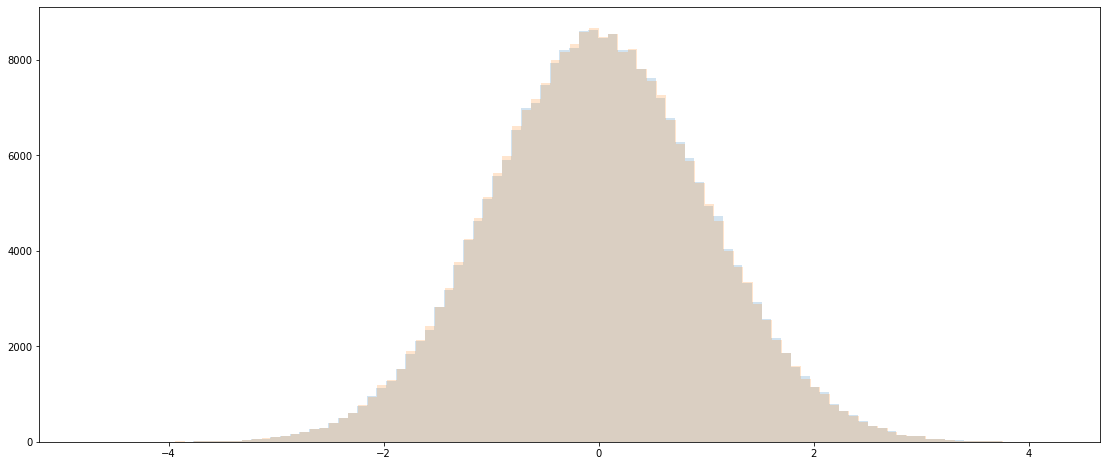

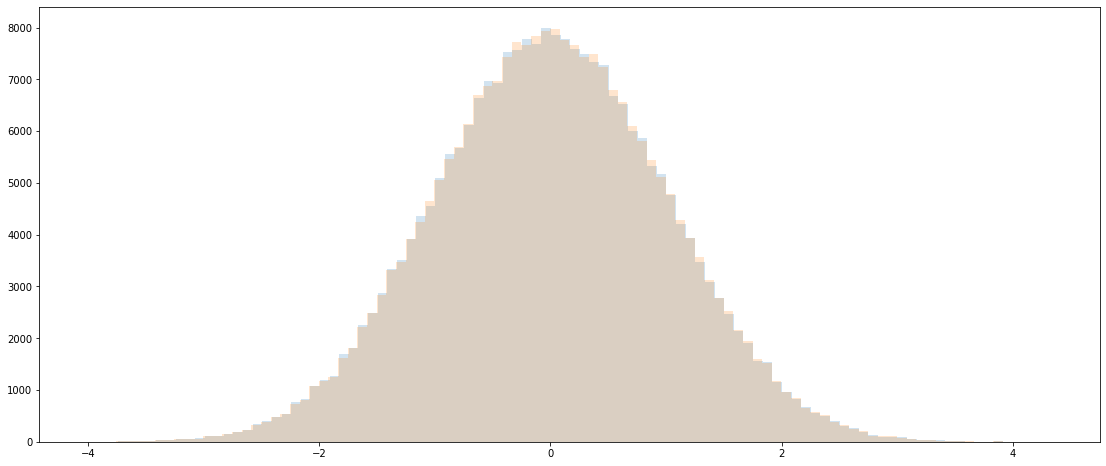

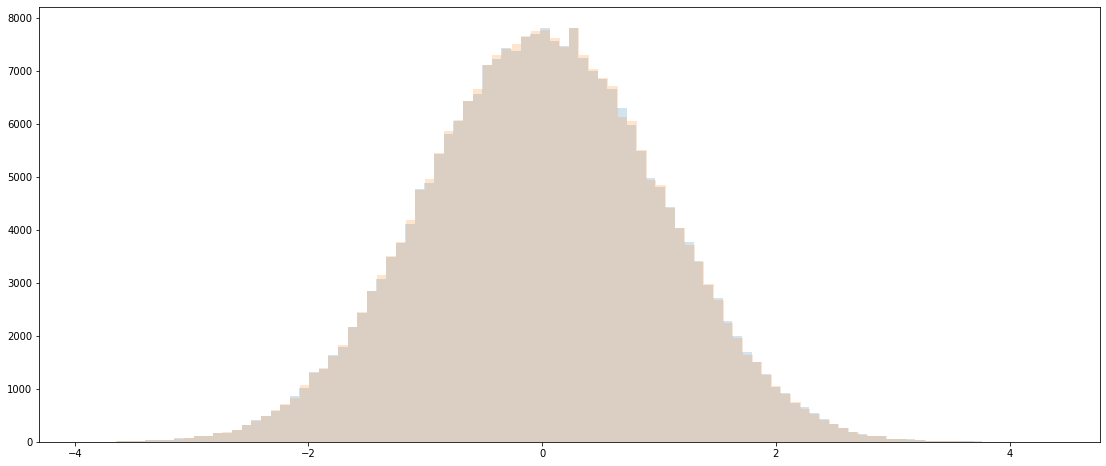

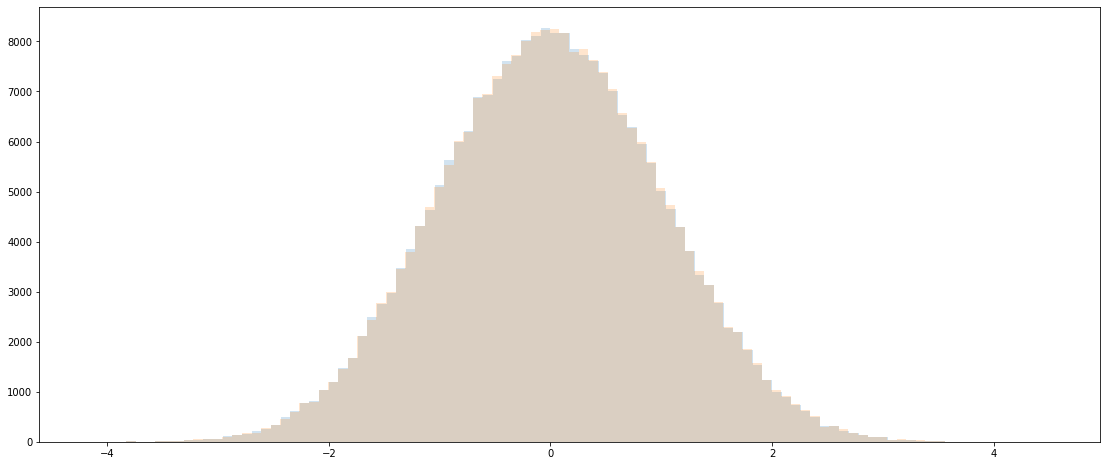

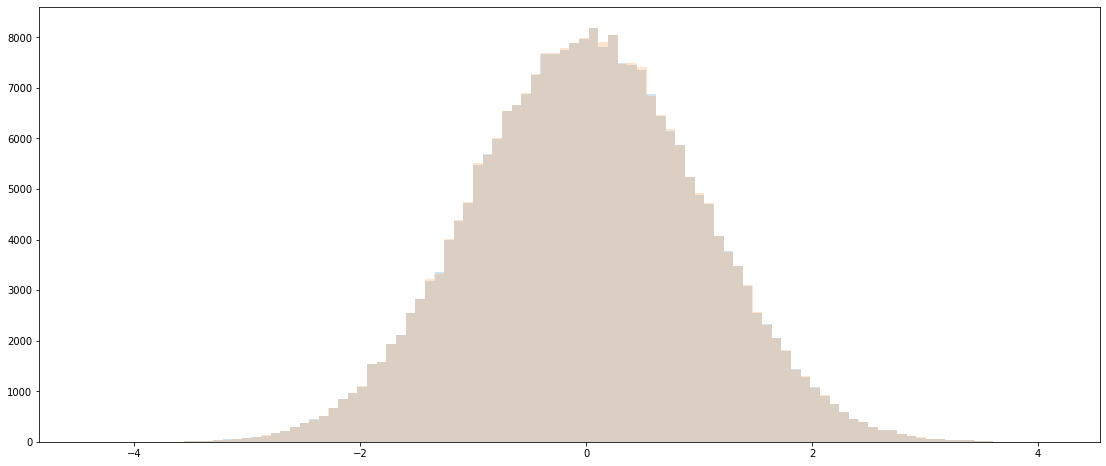

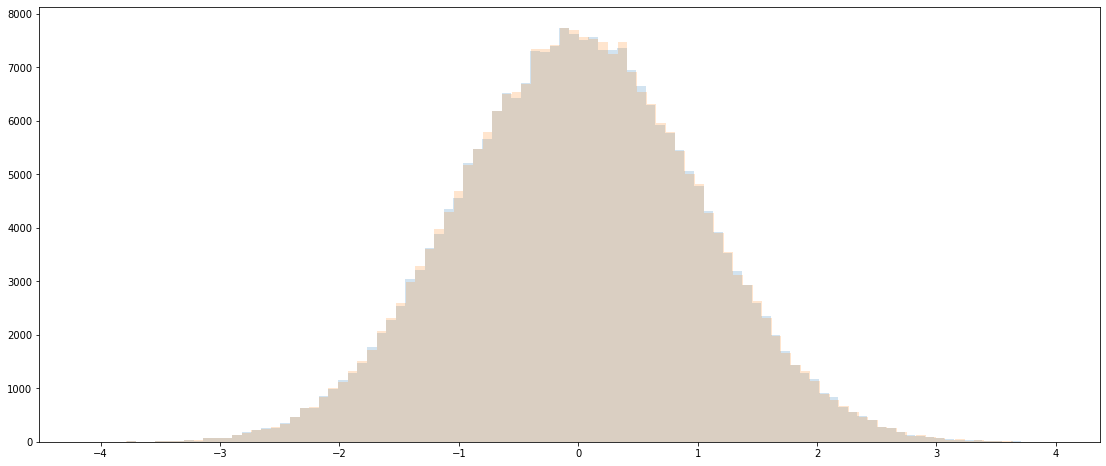

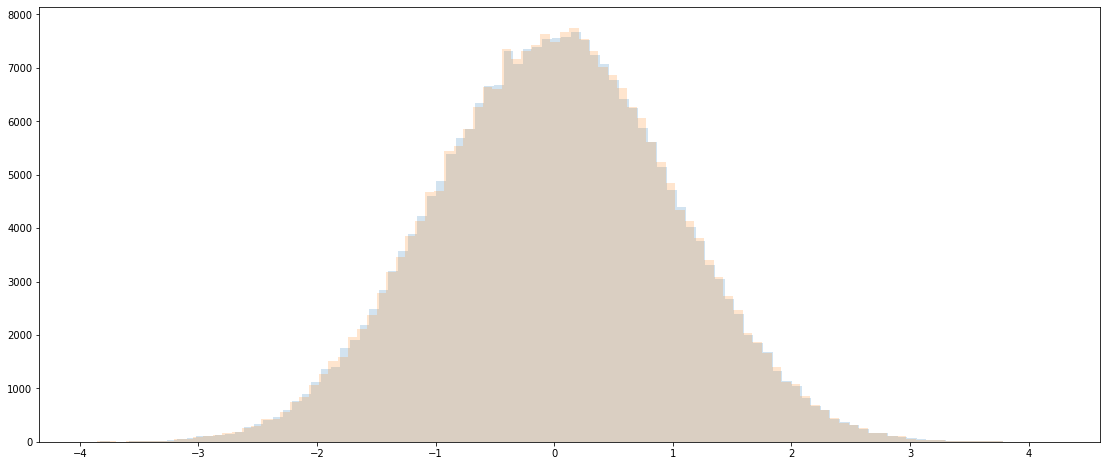

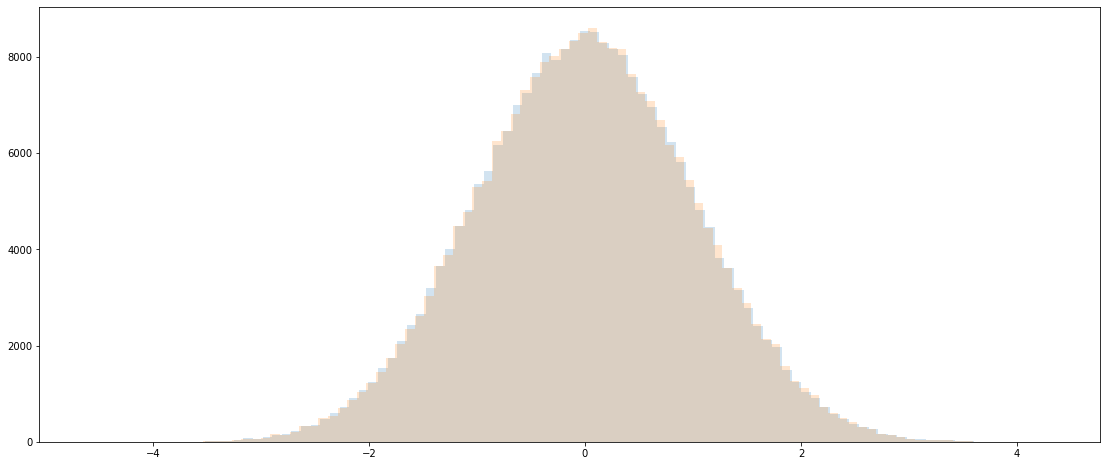

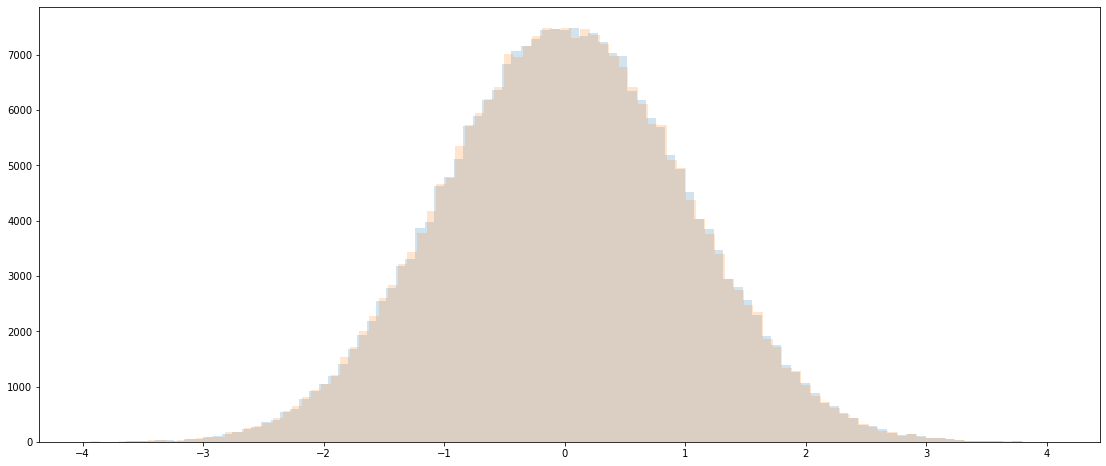

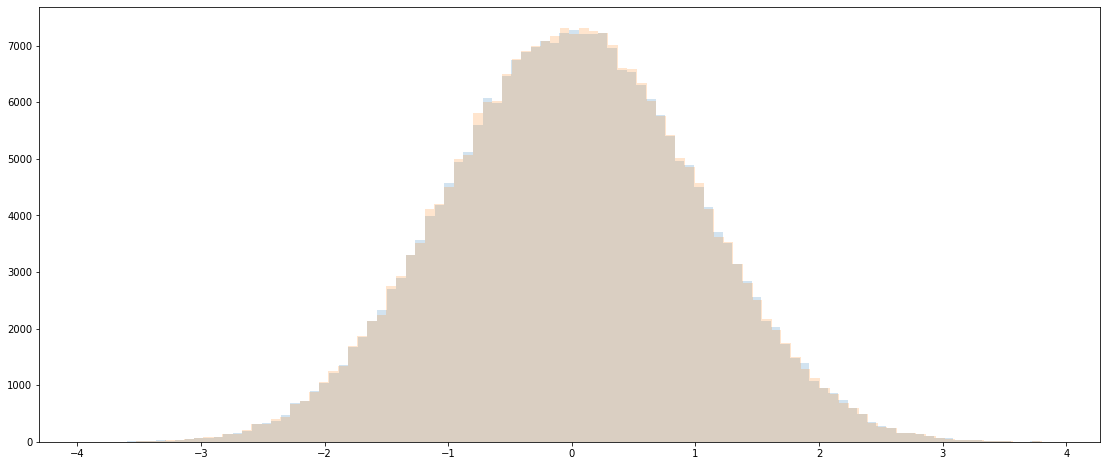

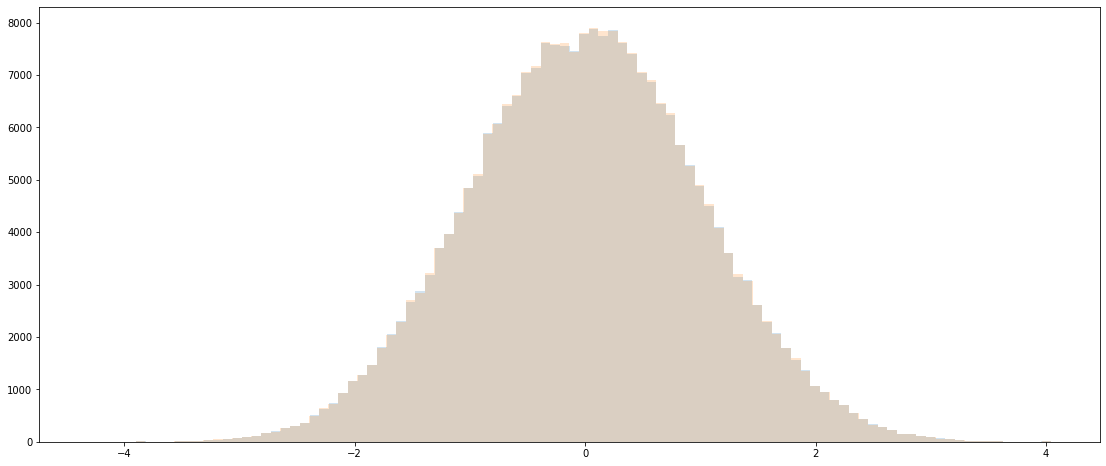

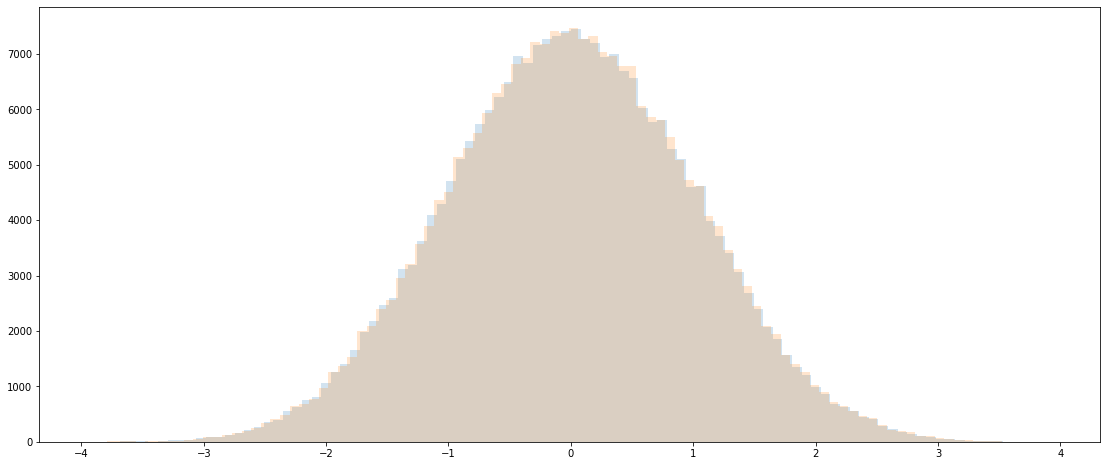

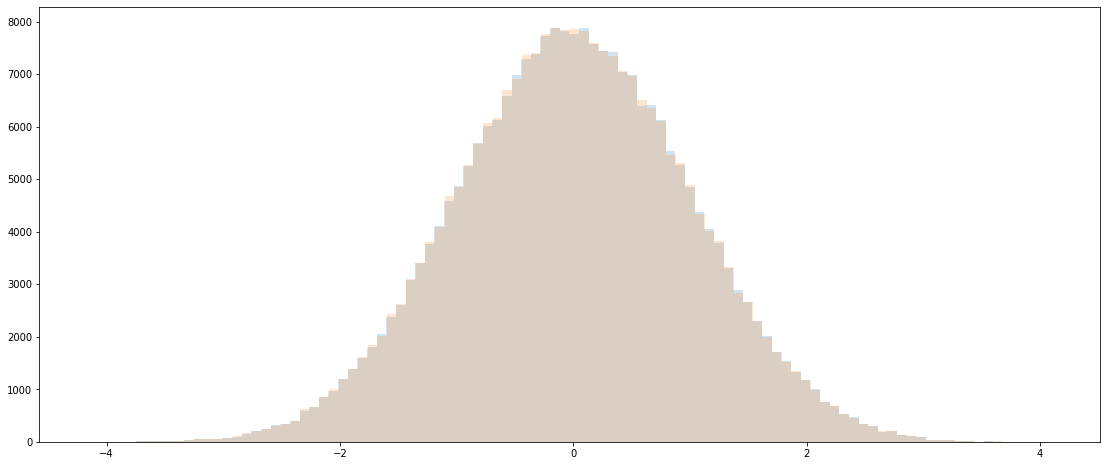

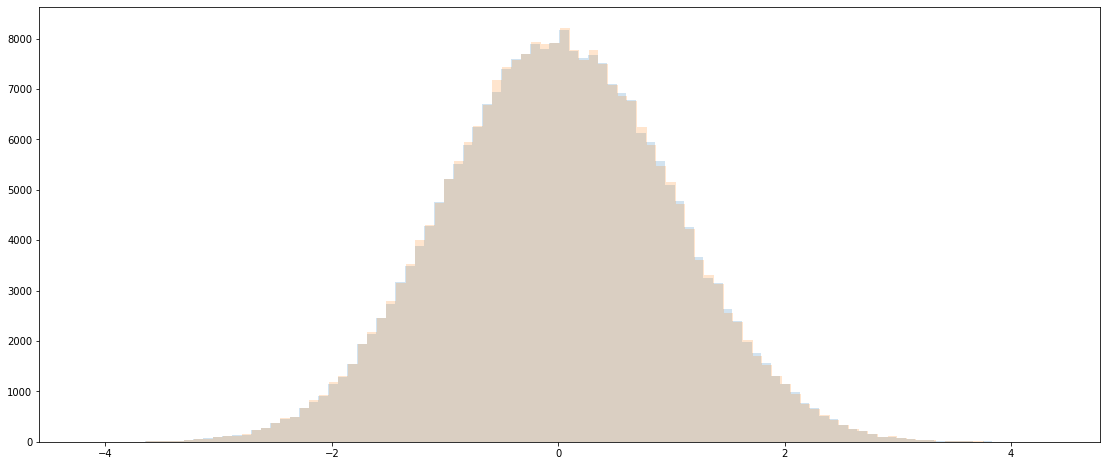

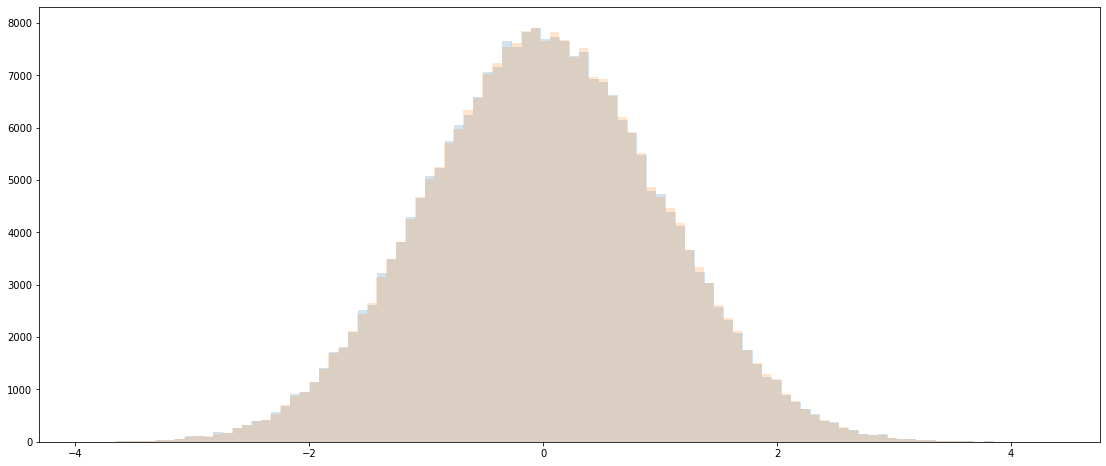

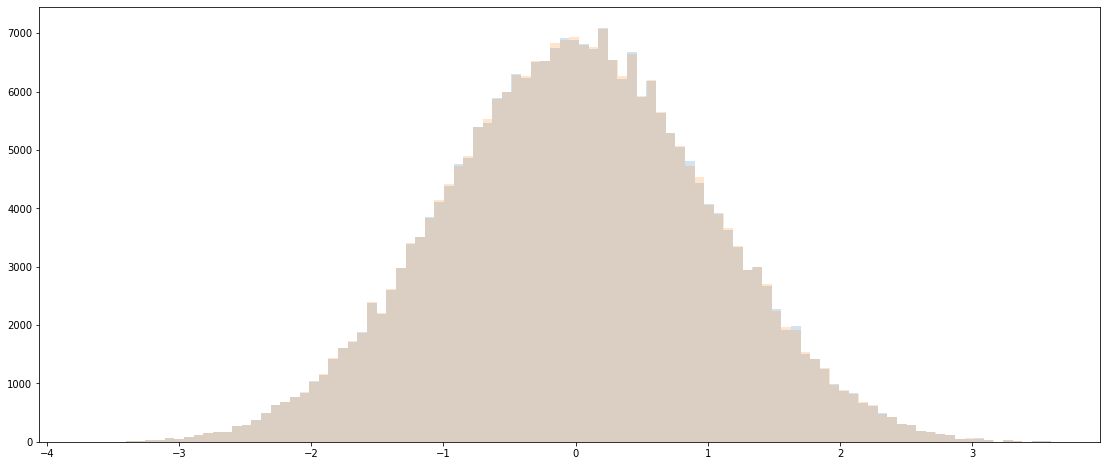

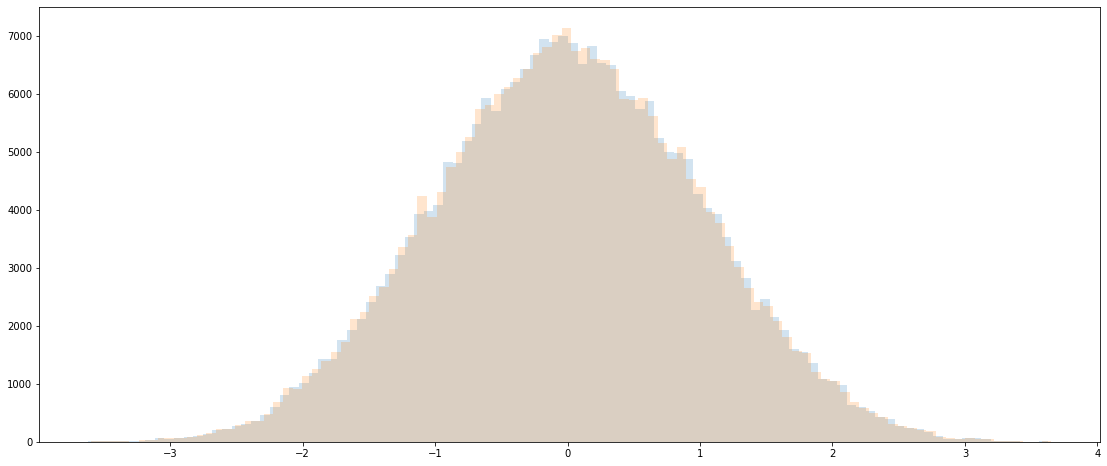

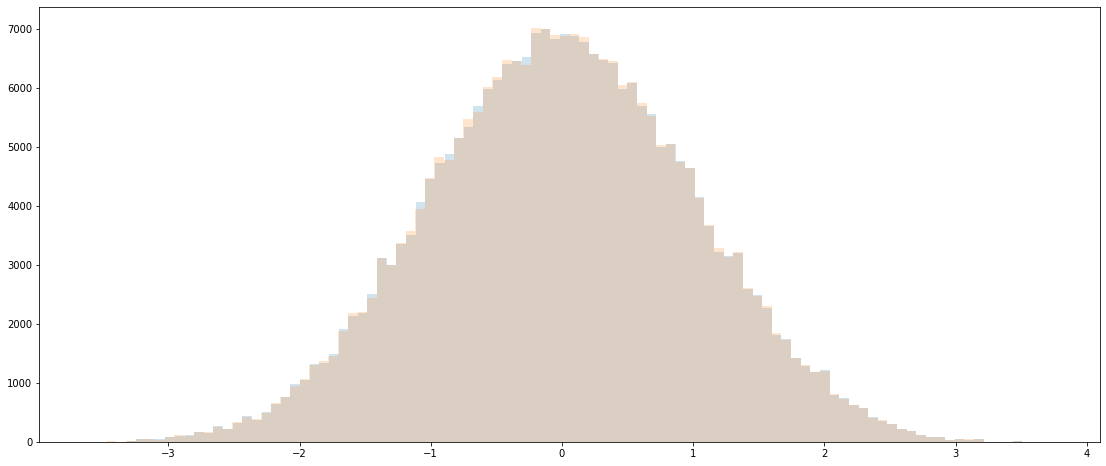

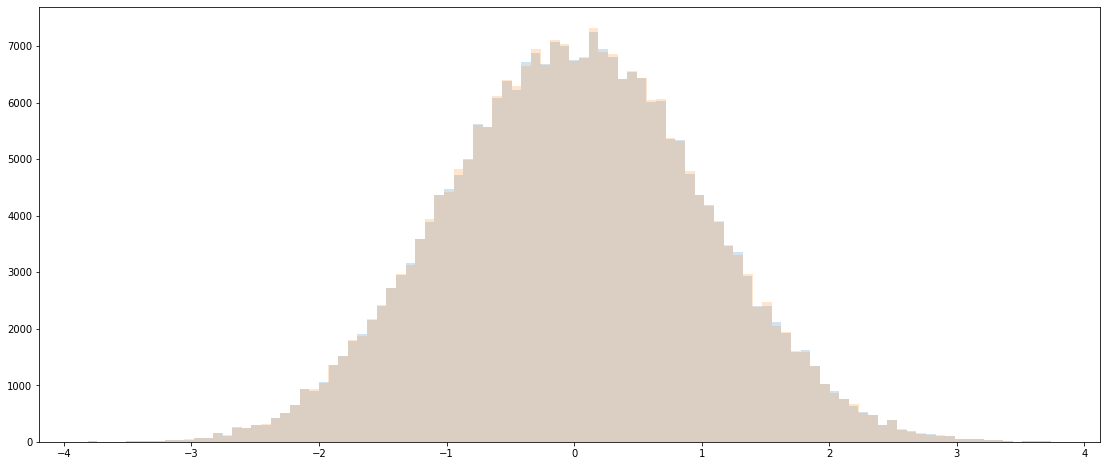

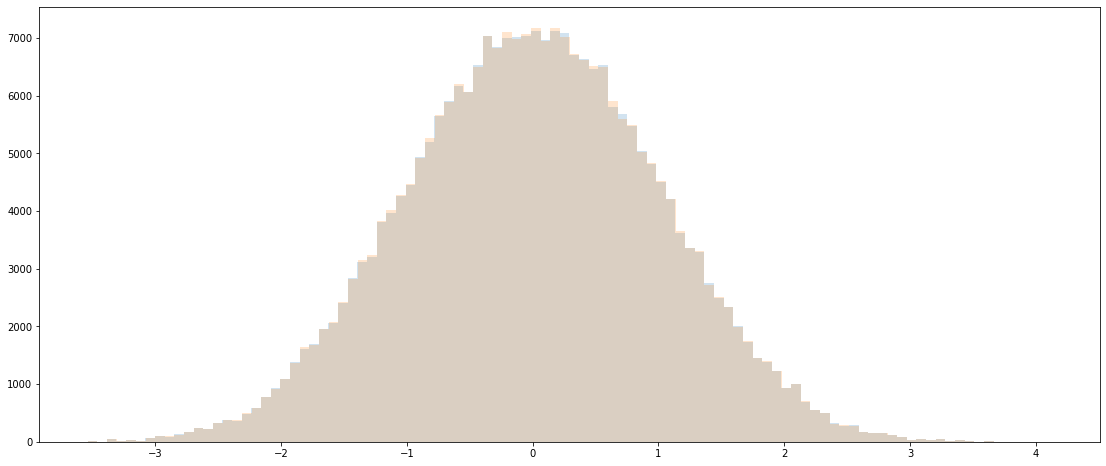

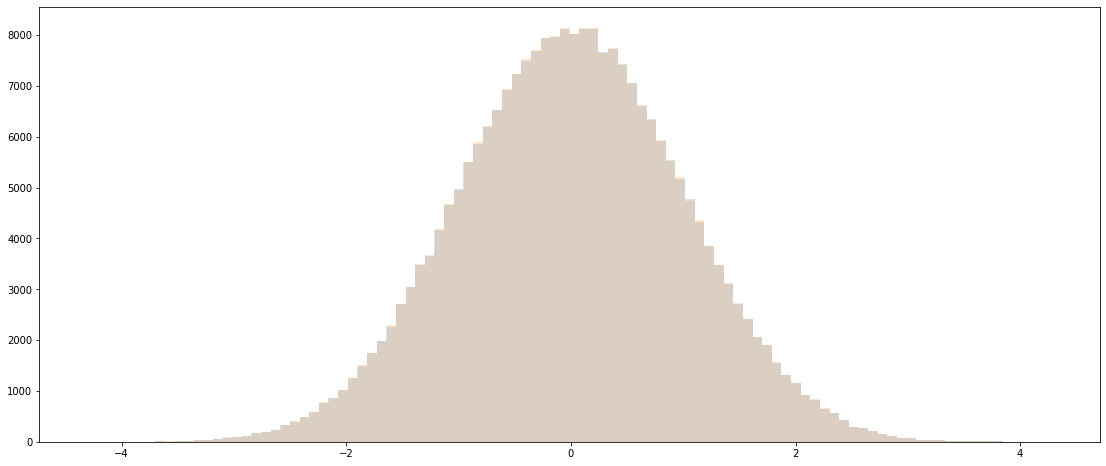

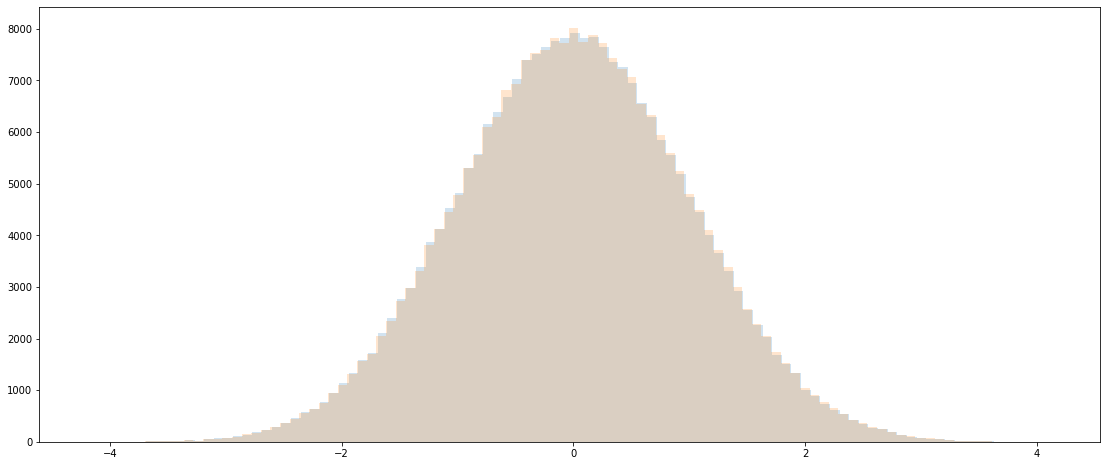

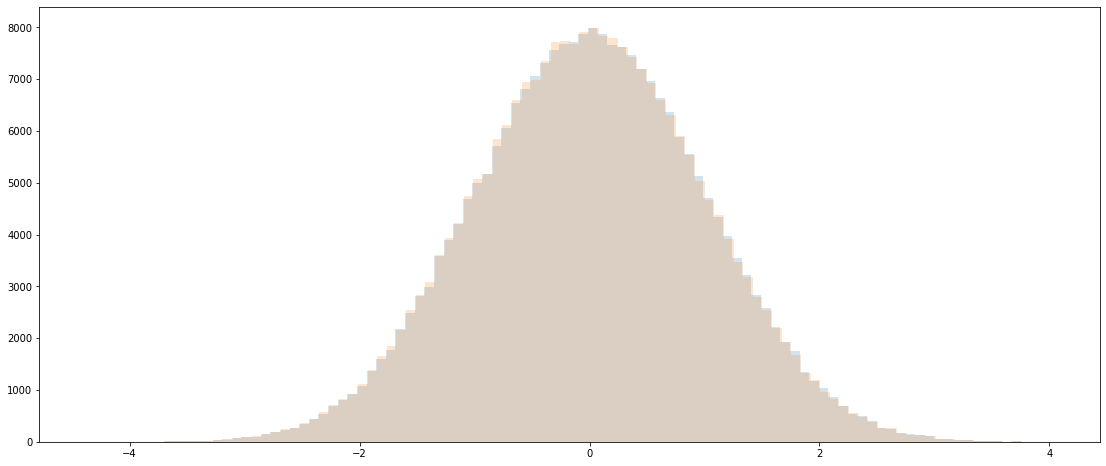

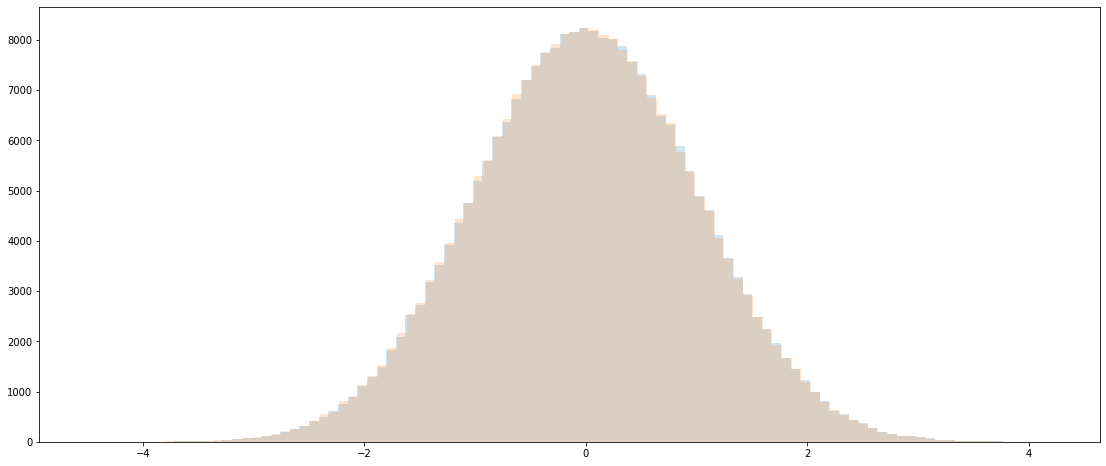

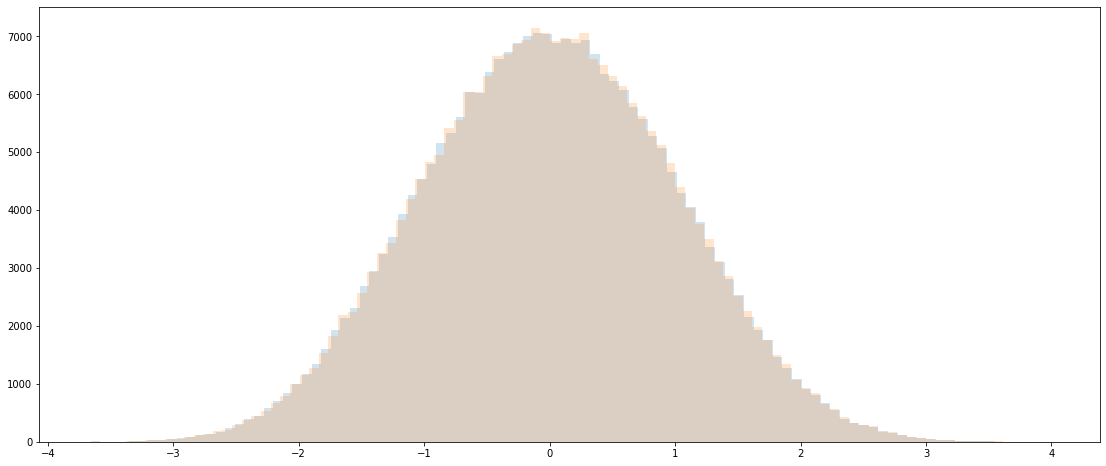

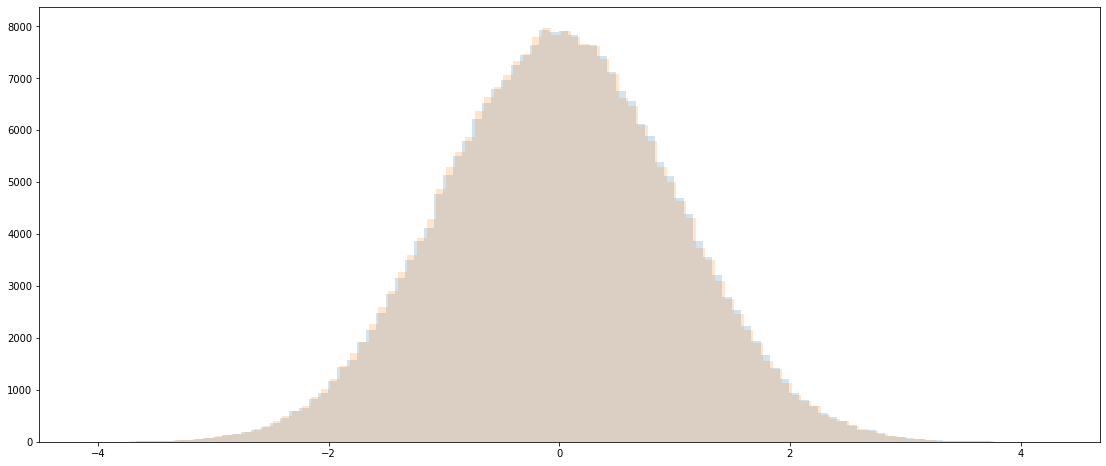

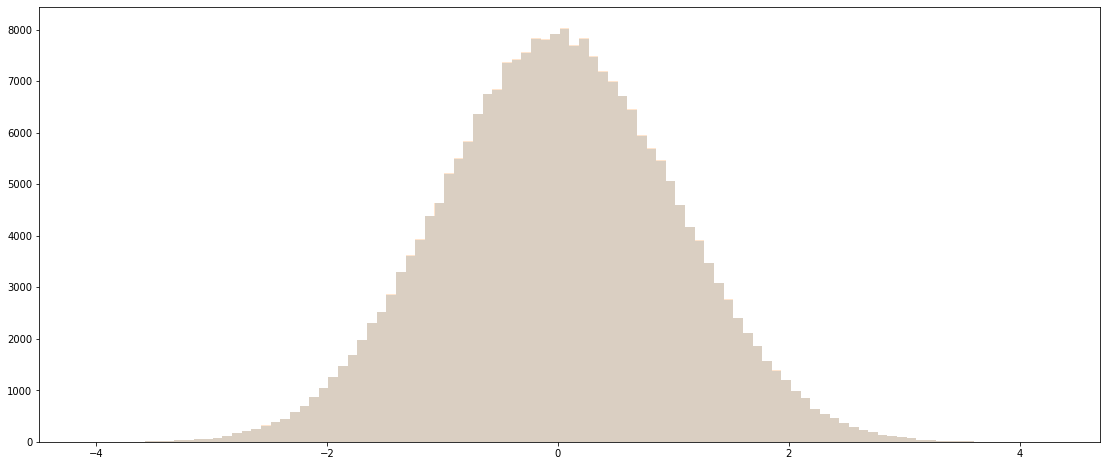

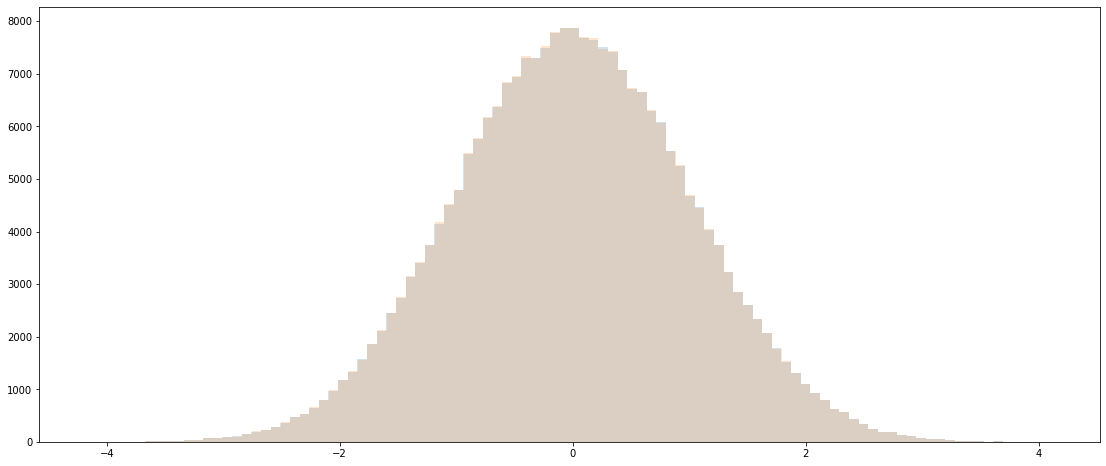

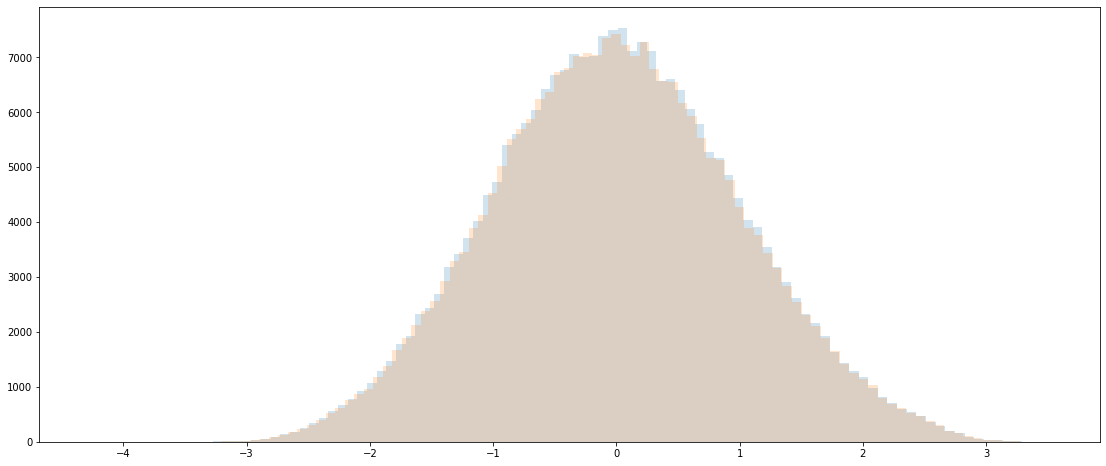

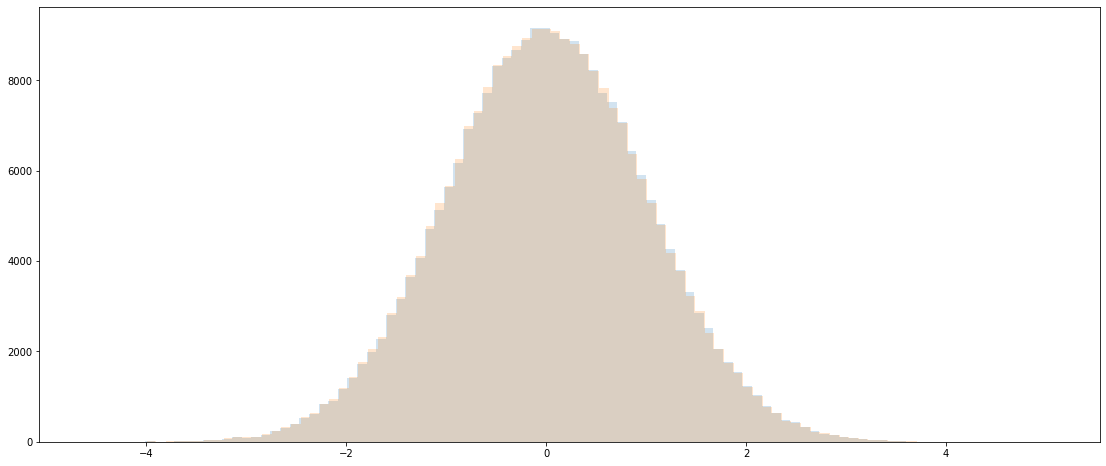

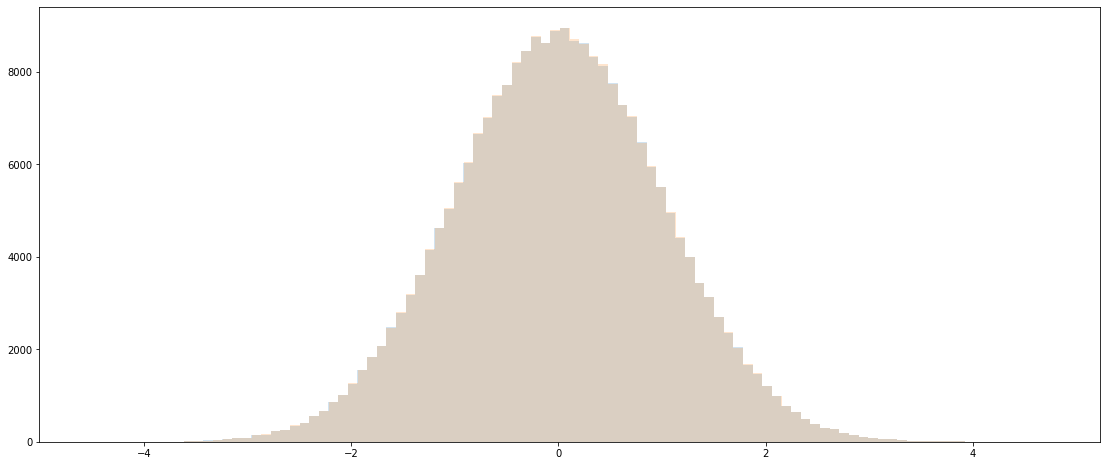

In [83]:
for i in range(52):
    plt.figure(figsize = (19,8))
    class_3 = np.where(labels ==3 )
    plt.hist(samples[class_3,i,:].reshape(-1,1), alpha = 0.2,bins = 100)
    class_0 = np.where(labels ==0)
    plt.hist(samples[class_0,i,:].reshape(-1,1), alpha = 0.2,bins = 100)
    plt.show()
    